In [1]:
# Importar las librerias necesarias para hacer un EDA   
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Leer los datos
df_imss = pd.read_csv('data/tidy_imss.csv')
df_agp = pd.read_csv('data/tidy_agricultura_ganaderia_pesca.csv')

> Dado que estamos trabajando con dos tablas tidy, haremos un análisis primero para uno y después repetiremos el análisis para el segundo.

#### Análisis con el datraframe

In [3]:
# Ver la información de los datos del IMSS
df_imss.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629639 entries, 0 to 629638
Data columns (total 14 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   rango_salarial              628979 non-null  object
 1   asegurados                  629639 non-null  int64 
 2   no_trabajadores             629639 non-null  int64 
 3   año                         629639 non-null  int64 
 4   mes                         629639 non-null  int64 
 5   fecha                       629639 non-null  object
 6   municipio                   629639 non-null  object
 7   sector_economico_1          629639 non-null  object
 8   sector_economico_2          629639 non-null  object
 9   sector_economico_4          629639 non-null  object
 10  tamaño_patronal             629639 non-null  object
 11  sexo                        629639 non-null  object
 12  rango_edad                  629639 non-null  object
 13  rango_salarial_descripcion  6

In [4]:
# Contamos la cantidad de datos nulos por columna
df_imss.isnull().sum()

rango_salarial                660
asegurados                      0
no_trabajadores                 0
año                             0
mes                             0
fecha                           0
municipio                       0
sector_economico_1              0
sector_economico_2              0
sector_economico_4              0
tamaño_patronal                 0
sexo                            0
rango_edad                      0
rango_salarial_descripcion      0
dtype: int64

In [5]:
# En vez de eliminar los datos nulos, los rellenamos con 'No especificado' dado que no 
# sabemos el motivo por el cual no se registraron
df_imss.rango_salarial.fillna('No especificado', inplace=True)

In [6]:
# Ahora empezamos a buscar los datos atípicos
# Para esto, vemos una descripción de los datos
df_imss.describe()

,asegurados,no_trabajadores,año,mes
count,629639.000000,629639.0,629639.000000,629639.000000
mean,5.770886,0.0,2020.024363,6.488351
std,17.426313,0.0,1.426229,3.453441
min,1.000000,0.0,2018.000000,1.000000
25%,1.000000,0.0,2019.000000,3.000000
50%,2.000000,0.0,2020.000000,6.000000
75%,4.000000,0.0,2021.000000,10.000000
max,1378.000000,0.0,2022.000000,12.000000


Observando las primeras dos columnas vemos que, en la columna de `asegurados` hay un valor que claramente es un outlier, pero por otra parte tenemos que la columna de `no_trabajadores` tiene un comportamiento atípico, dado que todos sus valores son ceros.


> Para este caso ignoraremos las columnas de año y mes. 

In [7]:
# Eliminamos la columna de no_trabajadores dado que no nos sirve para el análisis
df_imss.drop('no_trabajadores', axis=1, inplace=True)

<AxesSubplot: xlabel='asegurados', ylabel='sector_economico_4'>

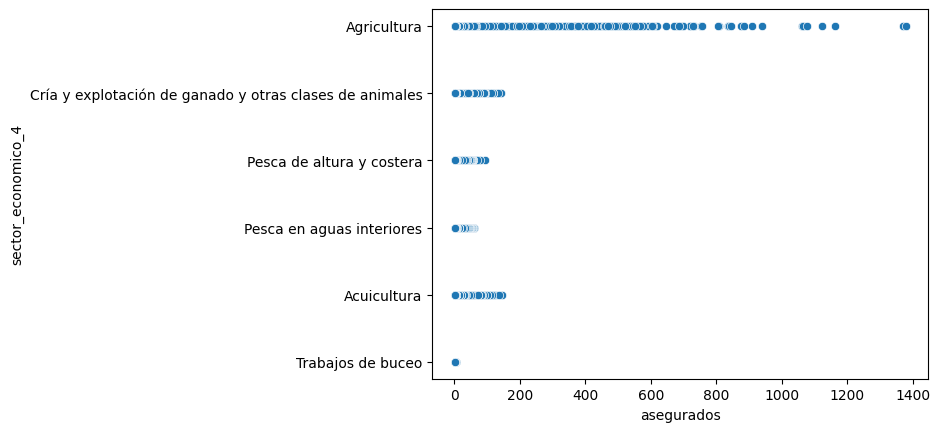

In [8]:
# Hacemos un scatterplot para ver la relación entre los asegurados y el sector económico
# Sabemos que el numero de asegurados depende del sector económico, pero queremos ver si
# hay algún sector que tenga una gran cantidad de asegurados o muy pocos
sns.scatterplot(x=df_imss.asegurados, y=df_imss.sector_economico_4)

Al ver esta gráfica pudieramos decir que no hay outliers, aunque pareciera lo contrario. Sabemos que hay zonas de agricultura que tienen una gran cantidad de trabajadores, pensar que hay zonas, o empresas, con casi 1400 trabajadores asegurados no debería extrañarnos. 

In [8]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EmpiricalCovariance, MinCovDet

# Creamos un dataframe con las columnas que nos interesan y las codificamos
df_outliers = df_imss[['asegurados', 'sector_economico_4']].copy()

# Creamos un encoder
le = LabelEncoder()

# Codificamos la columna de sector económico
df_outliers['sector_economico_4'] = le.fit_transform(df_outliers['sector_economico_4'])

# Convertimos el dataframe a un arreglo de numpy
X = df_outliers[['asegurados', 'sector_economico_4']].to_numpy()
X.shape

(629639, 2)

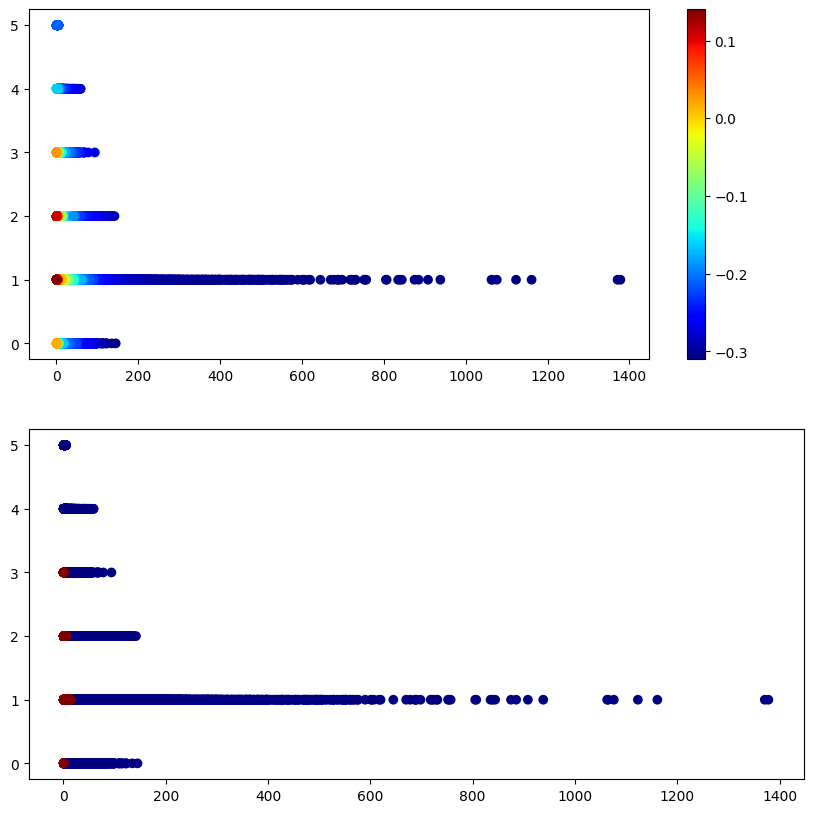

In [12]:
# Creamos el modelo de IsolationForest con el parámetro correcto 'n_estimators'
clf = IsolationForest(n_estimators=100)

# Entrenamos el modelo
clf.fit(X)

# Obtenemos el estimado de la función de decisión
estimado_IF = clf.decision_function(X)

plt.figure(figsize=(10, 10))

# Graficamos los datos
plt.subplot(2, 1, 1)
plt.scatter(x=X[:,0], y=X[:,1], c=estimado_IF, cmap='jet')
plt.colorbar() 

# Graficamos los datos nuevamente pero ahora con los datos atípicos resaltados
plt.subplot(2, 1, 2)
plt.scatter(x=X[:,0], y=X[:,1], c=np.where(estimado_IF > 0, 1, 0), cmap='jet')
plt.show()

Aquí podemos observar cómo el valor que es mayor entre los demás, para el grupo de Agricultura, no resultó ser un valor atípico, sin embargo, para este y otros grupos, los valores más pequeños resultan serlo.

Matrices de covarianza estimadas:
MCD:
[[ 0.44967636 -0.03642212]
 [-0.03642212  0.6140083 ]]
MLE:
[[303.67589884  -0.81506644]
 [ -0.81506644   0.68851922]]


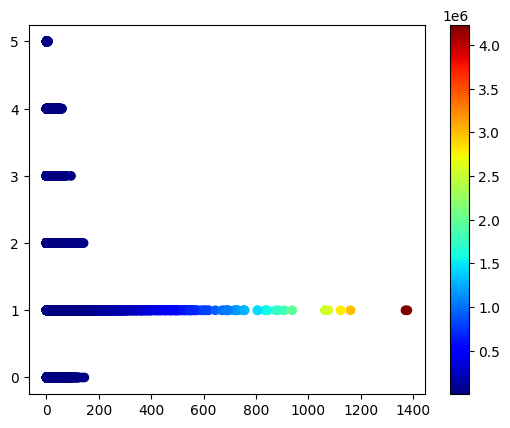

In [14]:
# Estimador robusto (MCD)
robust_cov = MinCovDet().fit(X)
estimado_MCD = robust_cov.mahalanobis(X)

# Estimador empírico (MLE)
emp_cov = EmpiricalCovariance().fit(X)
estimado_MLE = emp_cov.mahalanobis(X)

print('Matrices de covarianza estimadas:\n' +
      f'MCD:\n{robust_cov.covariance_}\n' +
      f'MLE:\n{emp_cov.covariance_}')

plt.scatter(x=X[:,0], y=X[:,1], c=estimado_MCD, cmap='jet')
plt.colorbar()
plt.show()

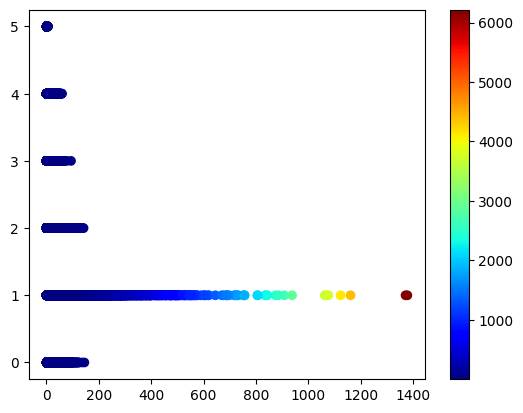

In [15]:
plt.scatter(x=X[:,0], y=X[:,1], c=estimado_MLE, cmap='jet')
plt.colorbar()
plt.show()

#### Análisis con el datraframe AGP

In [9]:
# Ver la información de los datos de la agricultura, ganadería y pesca
df_agp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8734 entries, 0 to 8733
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ANO              8734 non-null   object 
 1   SECTOR           8734 non-null   object 
 2   CVE_DDR          8734 non-null   int64  
 3   CVE_MUN          8734 non-null   int64  
 4   ESPECIE_CULTIVO  8734 non-null   object 
 5   TIPO             8734 non-null   object 
 6   PRODTON          8734 non-null   float64
 7   VALPROD          8734 non-null   float64
dtypes: float64(2), int64(2), object(4)
memory usage: 546.0+ KB


In [10]:
# Contamos la cantidad de datos nulos por columna
df_agp.isnull().sum()

ANO                0
SECTOR             0
CVE_DDR            0
CVE_MUN            0
ESPECIE_CULTIVO    0
TIPO               0
PRODTON            0
VALPROD            0
dtype: int64

En este caso, vemos que no hay datos faltantes, por lo que procedemos con el siguiente paso.

In [11]:
# Ahora empezamos a buscar los datos atípicos
# Para esto, vemos una descripción de los datos
df_agp.describe()

,CVE_DDR,CVE_MUN,PRODTON,VALPROD
count,8734.000000,8734.000000,8.734000e+03,8.734000e+03
mean,146.071216,35.027364,3.961207e+05,4.293055e+04
std,10.000765,18.953632,6.939311e+06,2.434949e+05
min,139.000000,1.000000,0.000000e+00,0.000000e+00
25%,142.000000,20.000000,1.772500e+00,2.721250e+01
50%,144.000000,30.000000,3.260300e+02,9.229300e+02
75%,148.000000,49.000000,2.944762e+03,8.936125e+03
max,193.000000,72.000000,2.688360e+08,5.018198e+06


Aquí podemos observar que es un poco más difícil observar los datos atípicos, por lo que vamos a hacer uso de métodos gráficos que nos ayuden a encontrarlos.

> Las columnas de `CVE_DDR` y `CVE_MUN` serán ignoradas dado que son claves que ayudan a identificar regiones geográficas.

In [17]:
df_agp.groupby('SECTOR')[['PRODTON','VALPROD']].describe()

PRODTON                                                         \
              count          mean           std  min        25%        50%   
SECTOR                                                                       
Agricultura  5880.0  4.792170e+03  2.075406e+04  0.0    0.00000    252.000   
Ganadería    1610.0  2.148460e+03  9.287959e+03  0.0    3.53775    110.072   
Pesca        1244.0  2.755692e+06  1.821588e+07  0.0  428.75000  15732.000   

                                        VALPROD                               \
                      75%           max   count          mean            std   
SECTOR                                                                         
Agricultura    2112.56250  5.854322e+05  5880.0  35057.671405  197859.375094   
Ganadería       779.53925  9.558728e+04  1610.0  72428.506959  325640.961270   
Pesca        158176.75000  2.688360e+08  1244.0  41966.548522  304480.345003   

                                                               
             min       25%      50%          75%          max  
SECTOR                                                         
Agricultura  0.0    0.0000   890.40   7944.96750  5018197.910  
Ganadería    0.0  183.4935  2540.54  33361.19750  3750770.000  
Pesca        0.0    6.9125   374.70   3834.78025  4483132.541